In [1]:
#Importing necessary packages
import pandas as pd
import networkx as nx
import collections
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
import plotly as py
import operator
from fa2 import ForceAtlas2
import matplotlib.colors as pltcolors
from community import community_louvain
import seaborn as sns
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
import string
import numpy as np
import math
from sklearn import preprocessing
import enchant
from sklearn.feature_extraction.text import TfidfVectorizer

# Explainer Notebook for final project in Social Graphs and Interactions

This notebook aims to explain all steps an calculations used for the final project in Social Graphs and Interactions (02805), which main findings are presented [here](https://benj1003.github.io/Goodreads_network/). The notebook has 4 main sections including the motivation behind the project, some basic stats to understand the dataset, the main analysis and finally a discussion about the findings. Please use the table of content below to navigate to the various sections.

## Table of Content
* [Motivation](#motivation)
* [Basic Stats](#basic-stats)
* [Analysis](#analysis)
    * [Generating the Network](#gen)
    * [Visualizing the Network](#viz)
    * [Community Detection](#com)
        * [Removing Highly Connected Nodes](#rem)
* [Discussion](#discussion)
* [Helper Functions](#help)

## Motivation <a class="anchor" id="motivation"></a>

This project is investigating a network of books. We want to explore how one book is related with the books that are recommended on this books site on Goodreads, an online database of books. The objective is to investigate if the list of recommendations creates a network, where for example the same books are recommended all the time making them highly influential in the literary society. Another outcome could be that books are mainly recommended other books within the same genre, which could limit readers to one sub-category of books. Or maybe no patterns are found at all. 
In addition to investigating the relationship between books, we investigate how correlated a books rating is, with the sentiment score of the book reviews. A hypothesis is that highly rating books will have a higher sentiment score in the reviews than a poorly rated book will. 
The network analysis and sentiment analysis is tied together when investigating whether the influential nodes in the notebook are also some of the books with highest sentiment or if it is something else that drives the high degree nodes. 

**The Dataset**

The information about the books are as mentioned taken from Goodreads. Goodreads is chosen as it holds information about almost every book and therefore creates a good platform to generate uniform data across the list of books. Goodreads also contains reviews of each book, which are crucial for second part of the analysis. 

The books chosen for the network are taken from the list ["Books Everyone Should Read At Least Once"](https://www.goodreads.com/list/show/264.Books_That_Everyone_Should_Read_At_Least_Once) referred to throughout this project as positive books. The list contains 21.618 books. To create the sentiment analysis poorly rated books are also necessary, and they are obtained from the list [“Worst Rated Books on Goodreads”](https://www.goodreads.com/list/show/23974.Worst_Rated_Books_on_Goodreads) referred to as negative books. This list contains 394 books. 

Information about each book is obtained by scraping the website here ([Click here to see scraping code (IKKE SAT IND!!!!!!!!!!!!)](https://google.com)). Acquiring the information through scraping is very slow and a time limitation has forced us to choose a finite number of books from the list of positive books. We managed to scrape basic information on the first 2,000 books from the list (including reviews for the first 450).
The following information about each book is acquired:
* Title
* Author
* Genre
* Rating
* Rating count (how many ratings a book has)
* List of recommended books
* Top 15 reviews of book

Our hope for the results of this analysis is for the reader to gain a better understanding of why some books are recommended often while others are never recommended even though they may have a high rating. Further, the reader should see how well a sentiment score obtained from the books reviews match with the generic metrics, such as rating, rating count and network influence (degree).



## Basic Stats <a class="anchor" id="basic-stats"></a>

This section provide a brief introduction to the dataset. All the information scraped for the books can be found on this Github page, and thus cloning the full reposetory enables you to run script (The information can also be obtained in csv-format [here (LINK IKKE INDSAT!!!!!)](https://google.com)). OBS. The code below manages reading the information into a dataframe and exploring the entries. 

In [2]:
# Reading the list of books as dataframe
pos_books = pd.read_pickle("books.pcl")

In [3]:
# Printing the first 5 entries of the dataframe
pos_books.head()

,title,author,genre,rating,rating_count,related,review
0,To Kill a Mockingbird,Harper Lee,Classics,4.27,4058926,"[Harry Potter and the Deathly Hallows, Lord of...",[[\n \n Why is it when I p...
1,Harry Potter and the Sorcerer's Stone,J.K. Rowling,Fantasy,4.47,6186514,"[Lord of the Flies, A Wrinkle in Time, Speak, ...",[[\n\n \nUPDATE OCTOBER 2019\nShould I try to ...
2,Pride and Prejudice,Jane Austen,Classics,4.25,2662196,"[Harry Potter and the Deathly Hallows, Lord of...",[[\n \n 6.0 stars. Confess...
3,The Diary of a Young Girl,Anne Frank,Nonfiction,4.13,2474246,"[Lord of the Flies, Harry Potter and the Death...",[[\nWhy do we write reviews?You have a lot of ...
4,1984,George Orwell,Classics,4.17,2711604,"[Lord of the Flies, Harry Potter and the Death...",[[\nThis book is far from perfect. Its charact...


In [6]:
printmd("**Statistics about the ratings:**")
print(f"The book with the highest rating is {pos_books.title[pos_books.rating.idxmax()]}\
with a rating of {pos_books.rating.max()}")
print(f"The book with the lowest rating is {pos_books.title[pos_books.rating.idxmin()]}\
with a rating of {pos_books.rating.min()}")
print(f"The average rating of the books are {pos_books.rating.mean():.2f}")
print()
printmd("**Statistics about the rating count:**")
print(f"The book with the highest rating count is {pos_books.title[pos_books.rating_count.idxmax()]}\
with a rating count of {pos_books.rating_count.max():,}")
print(f"The book with the lowest rating count is {pos_books.title[pos_books.rating_count.idxmin()]}\
with a rating count of {pos_books.rating_count.min():,}")
print(f"The average rating count of the books are {pos_books.rating_count.mean():,.2f}")

**Statistics about the ratings:**

The book with the highest rating is Otuna's Flutewith a rating of 5.0
The book with the lowest rating is Dark Roomswith a rating of 3.1
The average rating of the books are 4.05



**Statistics about the rating count:**

The book with the highest rating count is Harry Potter and the Sorcerer's Stonewith a rating count of 6,186,514
The book with the lowest rating count is A Debt Free Youwith a rating count of 12
The average rating count of the books are 200,106.80


**Statistics about genre**

Next the count of entries for each genre is investigated. As seen in the output below most of the books fall into a few genres, whereas many genres are represented by very few books. Therefore, we have decided to only keep the top 15 genres and group the remaining into a new category called "Miscellaneous".   

In [7]:
pos_books.groupby("genre")["genre"].count().sort_values(ascending=False)

genre
Fiction           497
Classics          256
Fantasy           197
Nonfiction        171
Young Adult       113
                 ... 
Health              1
GLBT                1
Food and Drink      1
Erotica             1
Action              1
Name: genre, Length: 66, dtype: int64

In [8]:
# Taking only the top 15 genres and grouping the remaining 
genres_accepted = pos_books.groupby("genre")['genre'].count().sort_values(ascending=False)[0:15]
pos_books.loc[~pos_books.genre.apply(lambda x: x in list(genres_accepted.index)), 'genre'] = "Miscellaneous"

In [9]:
pos_books.groupby("genre")["genre"].count().sort_values(ascending=False)

genre
Fiction            497
Classics           256
Miscellaneous      249
Fantasy            197
Nonfiction         171
Young Adult        113
Historical          94
Science Fiction     56
Horror              53
Romance             40
History             39
Childrens           38
Mystery             34
Philosophy          32
Poetry              26
Contemporary        22
Name: genre, dtype: int64

**Statistics about reviews**

Next, we investigate the reviews for each book. As mentioned, we have not obtained reviews for all the positive books, as this by far was the most time-consuming part of the scraping. Only reviews for the first 444 books has been obtained. This, though, provide a more homogeneous dataset when comparing with the negative books, as this list contains approximately the same number of books.

In [10]:
books_reviewed = pos_books[pos_books.review.notna()].reset_index(drop=True)
print(f"The number of books with acquired reviews are {len(books_reviewed)}.")

The number of books with acquired reviews are 442.


In [11]:
tokenizer = RegexpTokenizer(r"\w+")

tokens_count_list = []
for j in range(len(books_reviewed)):
    tokens_count = 0
    for i in range(len(books_reviewed.review[j][0])):
        tokens = tokenizer.tokenize(books_reviewed.review[j][0][i])
        tokens_count += len(tokens)
    tokens_count_list.append(tokens_count)


In [12]:
books_reviewed = pd.concat([books_reviewed, pd.Series(tokens_count_list, name = "Token_count")], axis=1)

In [13]:
print(f"The book with the longest reviews is {books_reviewed.title[books_reviewed.Token_count.idxmax()]} \
with a token count of {books_reviewed.Token_count.max()}")
print(f"The book with the shortest reviews is {books_reviewed.title[books_reviewed.Token_count.idxmin()]} \
with a token count of {books_reviewed.Token_count.min()}")
print(f"The average token count for the reviews of the books are {books_reviewed.Token_count.mean():.2f}")

The book with the longest reviews is Cloud Atlas with a token count of 18724
The book with the shortest reviews is Guess How Much I Love You with a token count of 1108
The average token count for the reviews of the books are 6950.14


## Analysis <a class="anchor" id="analysis"></a>

### Generating the Network <a class="anchor" id="gen"></a>

First step in the analysis is to create the graph representing the books. The graph is created with all the books on the list as nodes and with edges that represents other books that are present in the list of "readers also enjoyed". Note that the graph is directed and thus an edge from book A to book B does not equal that there is an edge from book B to book A. 

In [14]:
# Generating directed graph
G = nx.DiGraph()

# Letting each node be a book from the positive list and adding rating and genre as attributes
for i in range(len(pos_books)):
    node = pos_books.iloc[i]
    G.add_node(node['title'], rating = node['rating'], genre = node['genre'])

In [15]:
# Creating edges from related books list to the books on the list
for i in range(len(pos_books)):
    node = pos_books.iloc[i]['title']
    connections = []
    for related in pos_books.iloc[i]['related']:
        if len(pos_books[pos_books['title'] == related]) == 1 :
            connections.append(related)
    for con in connections:
        G.add_edges_from([(con, node)])

In [16]:
print(f"The network consists of {nx.number_of_nodes(G)} nodes and {nx.number_of_edges(G)} edges.")

The network consists of 1917 nodes and 9898 edges.


With the network the degree distribution can be investigated. 

In [17]:
printmd("**Statistics about degree**")
print(f"The node with the highest degree is \
{list(dict(G.degree()).keys())[list(dict(G.degree()).values()).index(np.max(list(dict(G.degree()).values())))]} \
with degree {np.max(list(dict(G.degree()).values()))}")
print(f"This means that \
{list(dict(G.degree()).keys())[list(dict(G.degree()).values()).index(np.max(list(dict(G.degree()).values())))]} \
is recommended for {np.max(list(dict(G.degree()).values()))/len(pos_books)*100:.2f}% of the books on the list")
print(f"The average degree is {np.mean(list(dict(G.degree()).values())):.2f}")

**Statistics about degree**

The node with the highest degree is Harry Potter and the Deathly Hallows with degree 535
This means that Harry Potter and the Deathly Hallows is recommended for 27.91% of the books on the list
The average degree is 10.33


In [18]:
# Getting unique degree and count of each 
d = G.degree
d_between = nx.betweenness_centrality(G)
d_eigen = nx.eigenvector_centrality(G)
    
def hist_att(G, measure):
    if type(measure) == dict:
        sequence = sorted(measure.values())
    else:
        sequence = sorted([d for n, d in measure], reverse=True)
    Count = collections.Counter(sequence)
    deg, cnt = zip(*Count.items())
    return deg, cnt

In [19]:
deg, cnt_degree = hist_att(G, d)

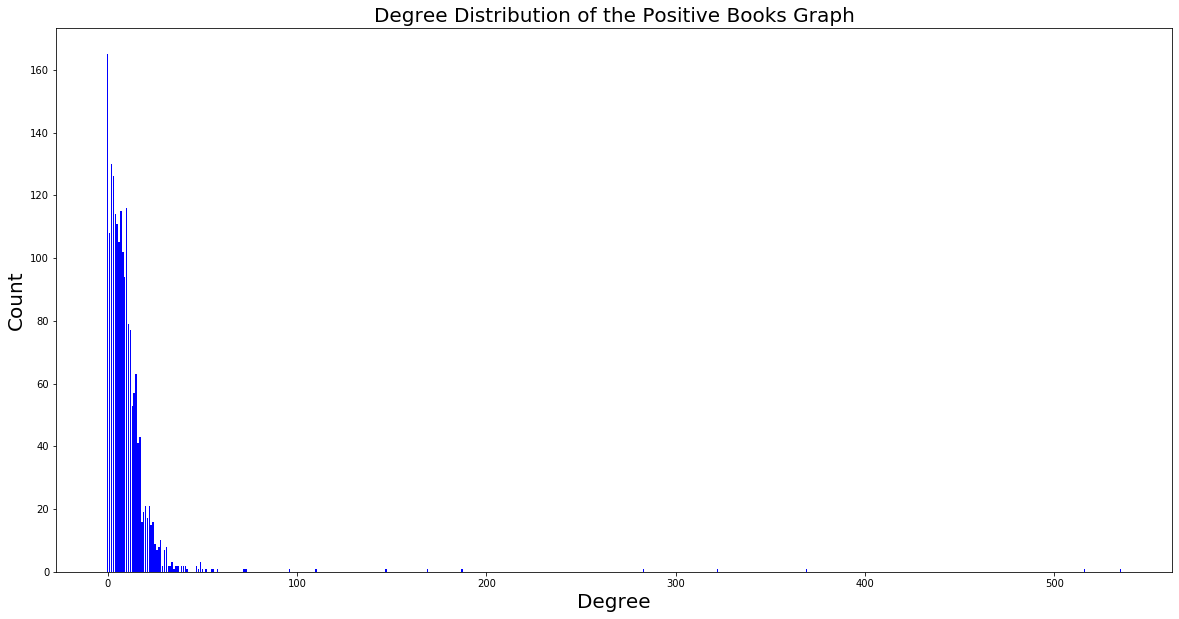

In [20]:
# Plotting degree distribution
plt.figure(figsize = (10,10))
plt.bar(deg, cnt_degree, width=0.80, color='b')
plt.title("Degree Distribution of the Positive Books Graph", fontsize = 20)
plt.xlabel("Degree", fontsize = 20)
plt.ylabel("Count", fontsize = 20)

plt.show()

Looking at the degree distribution it is clear that few books have a very large degree while the majority of the books have a degree below 50. This indicates that there are a few select books that gets recommended for most other books on the list. To investigate how central these books are for the network the betweenness centrality and eigenvector centrality are found. 
Betweenness centrality is a measure of how many shortest paths passes through a given node. For our network a high betweenness centrality would indicate a gateway book, meaning if you read book A you may not be recommended book B, but you get recommended book C. Book C will then recommend you book B, and the only reason you read book B is therefore because you also read book C. This makes book C very influential. 
Eigenvector centrality is also an indicator for how influential a node is. A node gets a high score if its neighboring node also have a high score. This would for our network mean that having a high eigenvector centrality is equal to being recommended a lot by other books that are also recommended a lot. 






**OBS DET NEDENFOR TROR JEG IKKE ER KORREKT, MEN JEG VED IKKE HVAD DER ER KORREKT... OBS**

A book with high degree but low eigenvector centrality could therefore be a book that is recommended alot, but does not recommend popular book itself.


In [21]:
# We now look at the nodes with the highest degree and their centrality measures 
# and outputs the N (10) with the highest degree
N = 10

degree_sort = pd.DataFrame(list(sorted(G.degree, key=lambda x: x[1], reverse=True)), columns = ("Name", "Degree"))
eigen_sort =   pd.DataFrame(list(sorted(nx.eigenvector_centrality(G).items(), key=operator.itemgetter(1), reverse=True)), columns = ("Name", "Eigenvector centrality"))
between_sort = pd.DataFrame(list(sorted(nx.betweenness_centrality(G).items(), key=operator.itemgetter(1), reverse=True)), columns = ("Name", "Betweenness centrality"))
sort = pd.merge(pd.merge(pd.merge(degree_sort,eigen_sort,on='Name'),between_sort,on='Name'), pos_books[['title', 'genre']], left_on = 'Name', right_on = 'title')
sort = sort.drop(['title'], axis = 1)
sort = sort.sort_values('Degree', ascending=False)

In [22]:
# Displaying top 10 degree books
sort[0:N]

,Name,Degree,Eigenvector centrality,Betweenness centrality,genre
0,Harry Potter and the Deathly Hallows,535,0.003696,0.129558,Fantasy
1,Lord of the Flies,516,0.001204,0.170643,Classics
2,The Handmaid's Tale,369,0.001102,0.023199,Fiction
3,A Wrinkle in Time,322,0.000863,0.002166,Fantasy
4,Anna Karenina,283,0.000846,0.040024,Classics
5,Speak,187,0.000735,0.002563,Young Adult
6,Watership Down,169,0.000873,0.000861,Classics
7,White Oleander,147,0.000962,0.005379,Fiction
8,The Elephant Tree,110,0.030922,0.008324,Miscellaneous
9,The Zombie Room,96,0.013046,0.000897,Miscellaneous


A few interesting remarks can be made from the table above. Looking at entry 8 we see that even though it has a smaller degree than entry 6 the betweenness centrality measure is almost 10 times bigger. 

**OBS IGEN HER ER JEG USIKKER PÅ OM DETTE ER RIGTIGT, MEN VED DET IKKE OBS**

This indicates that "The Elephant Tree" tends to be recommended through fewer iterations than "Watership Down" do. Further, it is noticed that "The Elephant Tree" at entry 8 has a higher eigenvector centrality than all others on the list. This shows that "The Elephant Tree" recommends the popular books more.

### Visulalizing the Network <a class="anchor" id="viz"></a>

In [23]:
def set_generic_node_attributes(G, color_by, scaling=1, grav=1, log=False,  n_f2_iter=2000):
    '''
    Function to get colors given a given group, and and positions found with the Force Atalas algorithm. 
    
    Parameters:
    G: networkx graph with attribute color_by
    color_by: attribute in graph G that graph should be colored by
    scaling: hyperparameter for Force Atlas algorithm. By default set to 1
    grav: gravity hyperparameter for Force Atlas algorithm. By default set to 1
    log: if True progress bar of tuning of Force Atlas will be displayed
    n_f2_iter: number of iterations for Force Atlas algorithm. By default set to 2000
    
    Return:
    colors: map for color of node in graph
    pos: positions for nodes in graph
    '''
    
    # Getting mapping of colors for nodes to seperate on genre:
    groups = set(nx.get_node_attributes(G,color_by).values())
    colors_tmp = list(pltcolors._colors_full_map.values())[0:len(groups)]
    cmap = dict(zip(groups, colors_tmp))
    nodes = G.nodes()
    colors = [cmap.get(G.node[n][color_by]) for n in nodes]

    #Defining positions using Force Atlas algorithm
    forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=scaling,
                        strongGravityMode=False,
                        gravity=grav,

                        # Log
                        verbose=log)
    
    pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=n_f2_iter)
    
    return colors, pos

In [24]:
# Getting color and position for plotting with color based on genre
color, pos = set_generic_node_attributes(G, 'genre', scaling=0.1, grav=10, log=False,  n_f2_iter=2000)
degree_list = list(dict(G.degree()).values())
size = [(x + 1)*20 for x in degree_list] 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



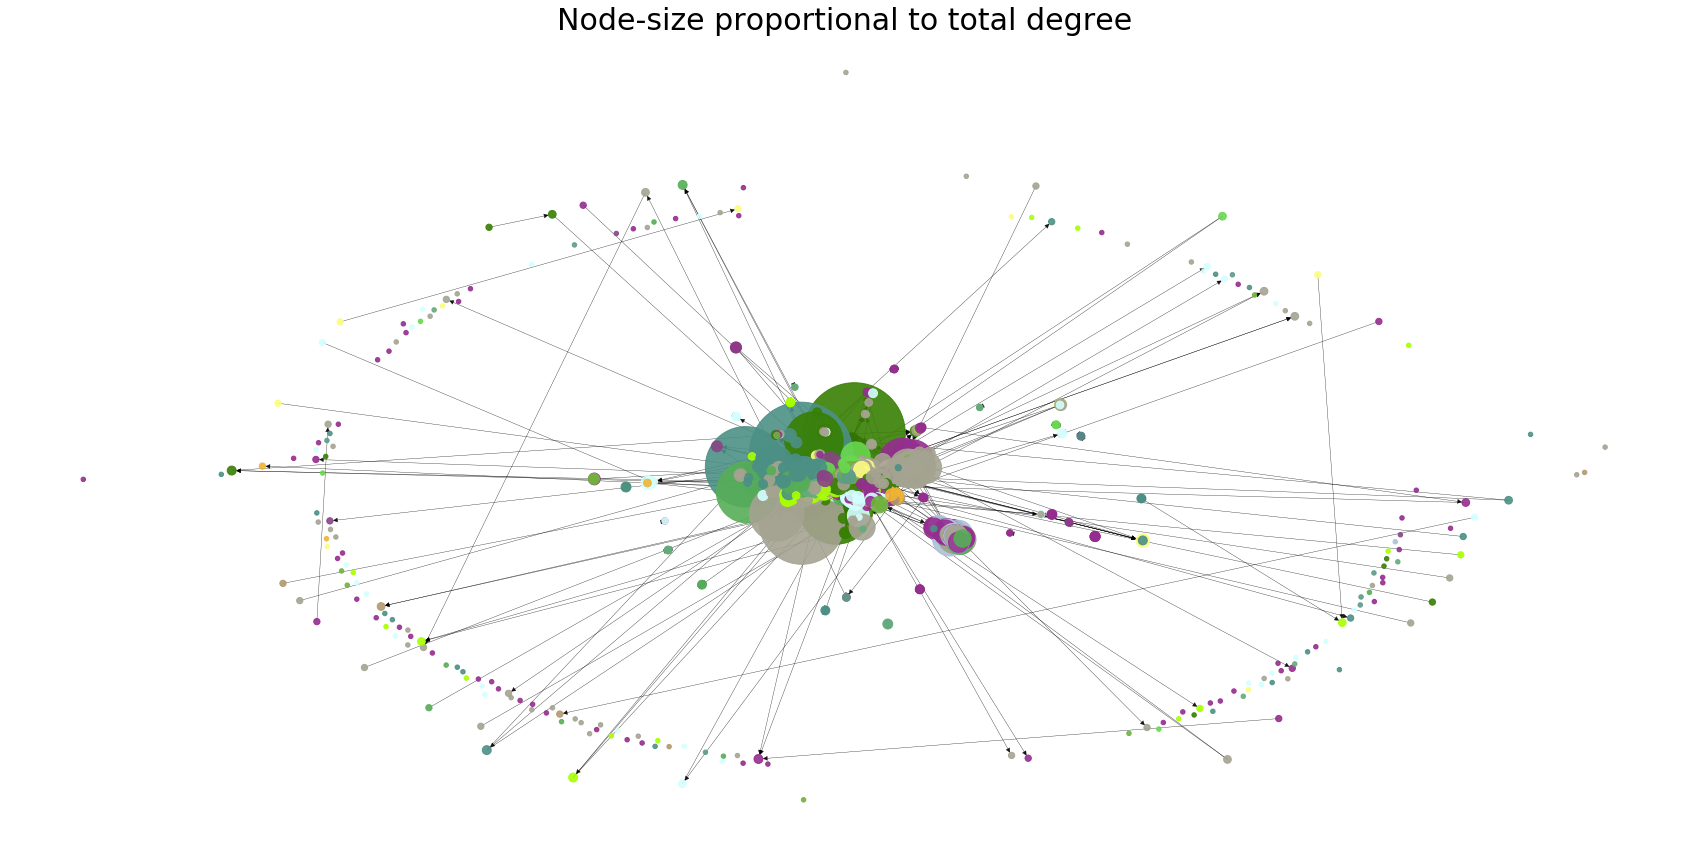

In [25]:
plt.figure(figsize=(30, 15))
plt.title("Node-size proportional to total degree", fontsize = 30)
nx.draw(G, pos, node_size=size, with_labels=False, width = 0.35, node_color=color, alpha=0.9)

This figures illustrates the network with node size proportional to total degree and color based on genre. The illustration supports the previously seen findings that few nodes have very high degree. It does though also indicate that the network contains hubs that seem correlated by genre. This is discussed further in the next section. 

In [ ]:
between_list = list(nx.betweenness_centrality(G).values())
eigen_list = list(nx.eigenvector_centrality(G).values())
size_between = [(x + 0.0001)*50000 for x in between_list] 
size_eigen = [(x)*5000 for x in eigen_list] 

In [ ]:
plt.figure(figsize=(30, 30))
plt.subplot(211)
plt.title("Node-size proportional to total degree", fontsize = 30)
nx.draw(G, pos, node_size=size_between, with_labels=False, width = 0.35, node_color=color, alpha=0.9)
plt.subplot(212)
plt.title("Node-size proportional to total degree", fontsize = 30)
nx.draw(G, pos, node_size=size_eigen, with_labels=False, width = 0.35, node_color=color, alpha=0.9)
plt.show()

### Community Detection <a class="anchor" id="com"></a>

Simply looking at the illustrations does, as mentioned, indicate that there is some clustering based on genres. But further investigation of community is needed in order to see, how well the genre actually do in clustering the data. We base our results on the modularity-score, which is a quantifiable measure of the density of links within communities compared to links between communities. Other measures, such as clustering coefficient could also be used, but we have decided to only use the modularity-score, as this provide a good measurement for our purpose.

The modularity-score can be found for each community as
$$ M_c = \frac{L_c}{L} - \left(\frac{k_c}{2L}\right)^2 $$
, where $L_c$ is the total amount of links within the community, L is the total amount of links in the network and $k_c$ is the total degree of all the nodes in the community.

This is easily generalized to the full network by summing over all the communities. Hence
$$ M = \sum_{c=1}^{n_c}\left[ \frac{L_c}{L} - \left(\frac{k_c}{2L}\right)^2 \right] $$
where $n_c$ represents the number of communities. 

The modularity-score for the full network with a given partition is a scale value between -1 and 1, where higher score implies better partition. 

The magnitude of the modularity-score cannot directly be interpreted. To do so we have identified theoretical communities using the modularity optimization algorithm, Louvain method for community detection. The communities found by the algorithm represent the best possible partitioning possible with the given network (Note: It is possible that other methods provide a slightly different result, which might provide a slightly better partition). The Louvain method is alterable and contains two phases. The method is initialized with each node as its own community. In the first step node i is grouped with each of the other nodes one by one and the modularity score is calculated. Once this value is calculated for all communities i is connected to, i is placed into the community that resulted in the greatest modularity increase. This is repeated for all nodes until no modularity increase is obtained. In phase two a new network is built, where each node represents a community found in phase 1, where edges between nodes within communities are represented as self-loops and links between nodes are weighted links proportional to how many within the community linked to the other community. With this network the process is repeated until no increase in modularity is found. This leads to the best possible (or at least very close to) partition in the network.

Comparing the modularity-score obtained with the optimal communities with the used partitioning, as well as comparing how each node is partitioned in the two groupings (for example using a confusion matrix), it is possible to see how well the used partition actually do in clustering the data.


In [26]:
def investigate_communities(G, base_community, initialise_random=False):
    '''
    Function that calculates the modularity given a base_community, as well as find optimal communities based on the 
    louvain algorithm. It furthermore generate a heatmap based on the confusion matrix generated from the 
    base_communities and the communities found by the louvain algorithm. 
    
    Parameters:
    G: networkx graph 
    base_community: the graph attribute that could be characterized as communities
    initialise_random: boolian value. If False (default) the louvain algirithm is initialized with the base_community, else random initialization
    
    Return:
    colors: map for color of node in graph
    pos: positions for nodes in graph
    '''
    #Investigates modularity for the community
    G_und = nx.to_undirected(G)
    modularity_score = community_louvain.modularity(nx.get_node_attributes(G_und, base_community), G_und)
    print(f"The modularity for {base_community} is: %.2f" %(modularity_score))
    
    # Initialising community detection by genre if specified in input
    if initialise_random == False:
        le = preprocessing.LabelEncoder()
        le.fit(list(nx.get_node_attributes(G_und, "genre").values()))
        list(le.classes_)
        t = le.transform(list(nx.get_node_attributes(G_und, "genre").values()))
        i = 0
        initialization = nx.get_node_attributes(G_und, "genre")
        for key, value in initialization.items():
            # do something with value
            initialization[key] = t[i]
            i += 1
        
        partition = community_louvain.best_partition(G_und, partition = initialization)
    else:
        partition = community_louvain.best_partition(G_und)
    
    communities = list(set(partition.values()))
    colors = list(pltcolors._colors_full_map.values())[0:len(communities)]
    cmap = dict(zip(communities, colors))
    print("The algorithm has identifies %.0f communities" %len(communities))
    
    modularity_score = community_louvain.modularity(partition, G_und)
    print("The modularity score based on the communities found by the algorithm is: %.2f" %modularity_score)
    
    # Calculating confusion matrix
    member_w_genre = pd.DataFrame(list(nx.get_node_attributes(G, 'genre').items()), columns = ['', 'genre'])
    member_w_com = pd.DataFrame(list(partition.items()), columns = ['', 'com'])
    conf_tmp = pd.merge(member_w_genre, member_w_com, how = 'inner', on = '')
    conf = conf_tmp.groupby(['com', 'genre']).count().unstack().T.fillna(0).astype(int)
    conf = conf.div(conf.sum(axis=1), axis=0)
    
    colsum = conf.sum(axis = 0, skipna = True).sort_values(ascending=False)
    top20 = colsum[:20].index
    
    fig = plt.figure(figsize = (6,6))
    sns.heatmap(conf[top20], cmap = 'jet')
    plt.title("Confusion matrix for communities")
    plt.xlabel('Community')
    plt.ylabel(base_community)
    
    return fig

The modularity for genre is: 0.38
The algorithm has identifies 11 communities
The modularity score based on the communities found by the algorithm is: 0.61


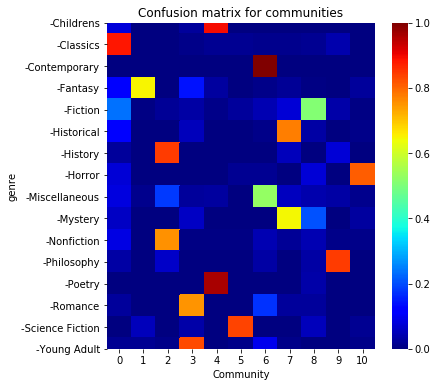

In [27]:
fig = investigate_communities(G, "genre", initialise_random=False)

Above we see a confusion matrix created by considering the genre as communities against the communities generated from the Louvrain algorithm. We note that the algorithm is initialized with each book in the genre, which influences the result heavily. With this method the Louvain algorithm outputs only 11 communities with a modularity score of 0.61, where the algorithm with a random initialization seen below constructs XXX communities with a modularity score of XXX (See below). It is deemed that the increase in interpretability values higher than the small decrease in modularity-score and therefore we use the genre initialization. We further note that the confusion matrix represents each category normalized by the number of books in that genre to make up for data imbalance.

From the confusion matrix we see that the communities do output communities that are consistent with the genres and thus genre seems like a good representative of communities, considering the network. We do, however, see that the modularity score is increased a lot when using the Louvrain algorithm.

We remind our self that the network consists nodes with very high degree, which may influence the results heavily, as these most likely are recommended by books from all genres. We investigate is this is the case by considering a subgraph, where the nodes in the top 1 percentile degree are removed.

The modularity for genre is: 0.38
The algorithm has identifies 207 communities
The modularity score based on the communities found by the algorithm is: 0.64


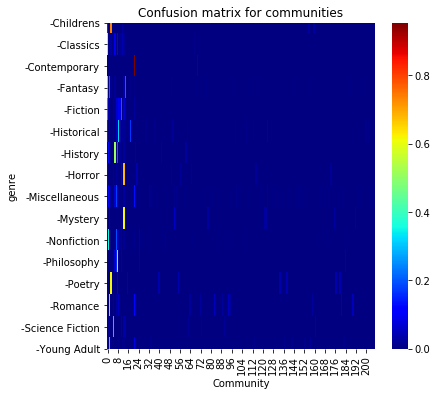

In [28]:
#**OBS SKAL DETTE MED?? OBS**

fig = investigate_communities(G, "genre", initialise_random=True)

#### Removing highly connected nodes <a class="anchor" id="rem"></a>

In [29]:
def remove_nodes_based_on_degree(G, n_top):
    ''' Function that removes the top n nodes based on degree and further removes the nodes
    that are left with no edges 
    
    Parameters:
    G: networkx graph 
    n_top: Number of nodes that should be removed. By default set to 7
    
    Return:
    G: networkx graph
    '''
    
    Degree_top1pct = pd.DataFrame(list(sorted(G.degree, key=lambda x: x[1], reverse=True)),
                                  columns = ("Name", "Degree")).iloc[n_top]["Degree"]
    remove_top = [node for node,degree in G.degree if degree >= Degree_top1pct]
    G.remove_nodes_from(remove_top)
    remove_0 = [node for node,degree in G.degree if degree == 0]
    G.remove_nodes_from(remove_0 )
    
    return G

In [30]:
n_removed = int(G.number_of_nodes()/100)
G_new = remove_nodes_based_on_degree(G, n_top=n_removed)
print(f"Excluding the {n_removed} nodes with highest indegree and removing nodes left without edges, results en a \
subnetwork with {nx.number_of_nodes(G_new)} nodes and {nx.number_of_edges(G_new)} edges.")

Excluding the 19 nodes with highest indegree, leaves only 1687 nodes with edges


In [31]:
# Getting color and position for plotting with color based on genre
colors, pos = set_generic_node_attributes(G_new, 'genre', scaling=0.1, grav=10, log=False,  n_f2_iter=2000)
degree_list = list(dict(G_new.degree()).values())
size = [(x + 1)*20 for x in degree_list]

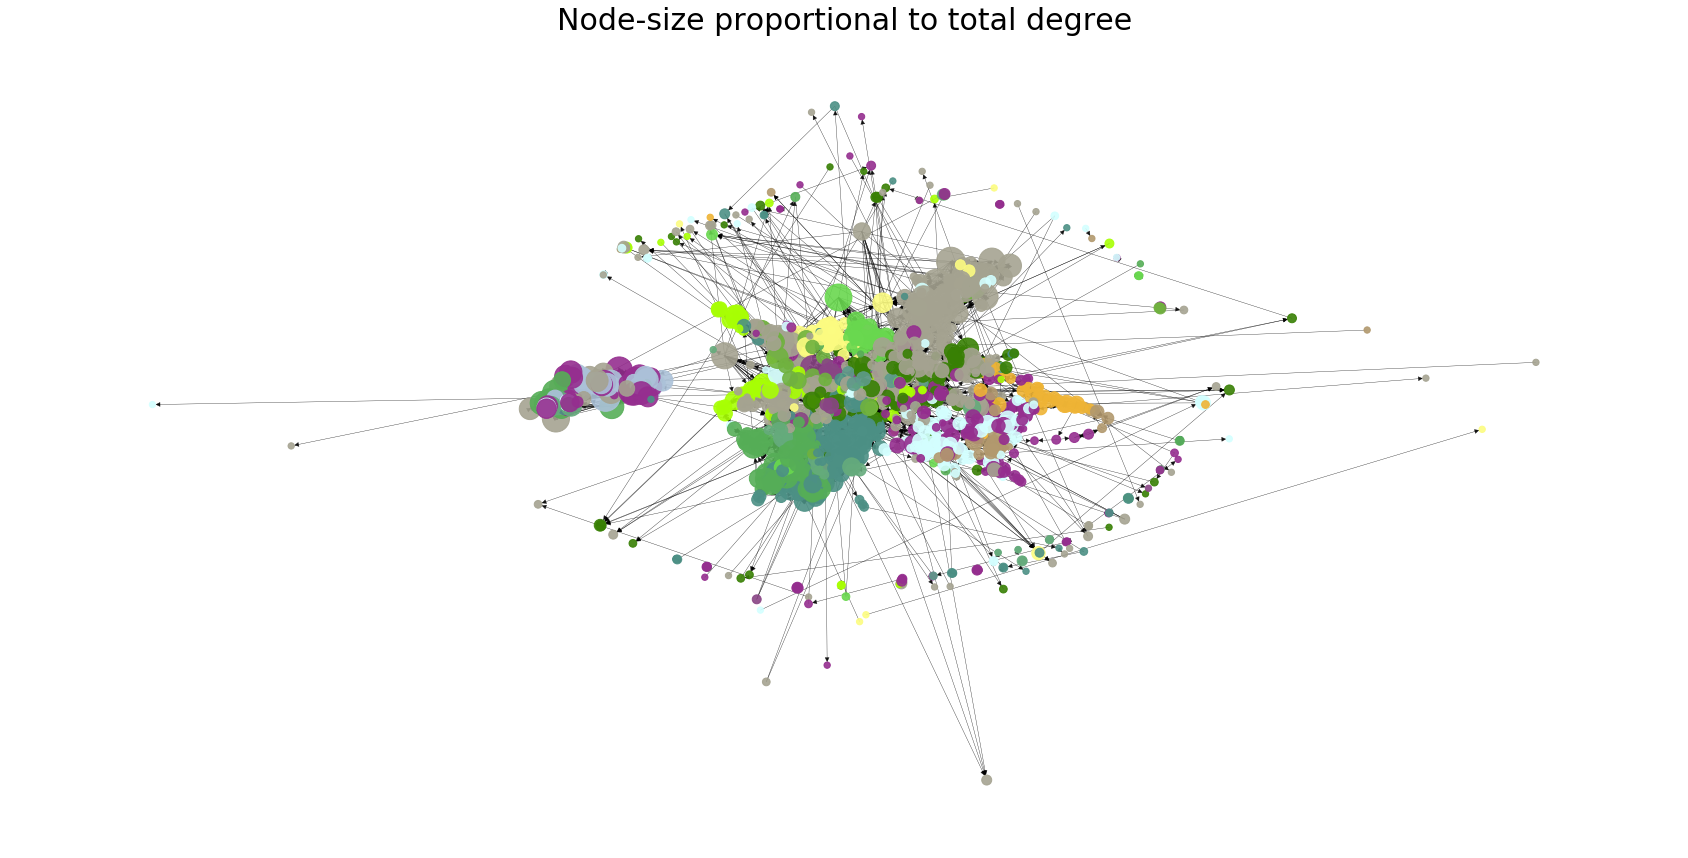

In [32]:
#plot
plt.figure(figsize=(30, 15))
plt.title("Node-size proportional to total degree", fontsize = 30)
nx.draw(G, pos, node_size=size, with_labels=False, width = 0.35, node_color=colors, alpha=0.9)

The modularity for genre is: 0.51
The algorithm has identifies 42 communities
The modularity score based on the communities found by the algorithm is: 0.81


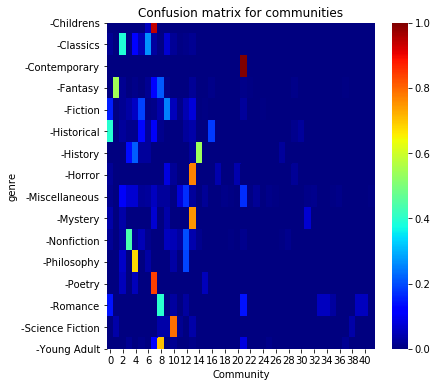

In [33]:
#Community
fig = investigate_communities(G_new, "genre", initialise_random=False)

**OBS REDO OBS**

Based on the network-illustration and especially the modularity score and confusion matrix, it is seen that removing the very connected nodes, generates a network with clear communities. With a modularity score of 0.52 we se that genre does represent communities very well. With the louvain algorithm it is possible to get the modularity sore up to 0.7 (even towards 0.8 with random initialization), but as the confusion matrix illustrates, each genre is our genre is mainly represented in each louvain community. 

### Text Analysis <a class="anchor" id="text"></a>

Next up is to investigate reviews of the books. This includes investigating the sentiments and general word prevalence in the reviews. The general assumption is, that most of the reviews for the books on the list will be highly positive given that the average rating of the books is 4.01. In order to get a reference point, information from some highly unpopular books on Goodreads is also collected and used in the sentiment analysis to distinguish between the two populations. 

The first analysis of the reviews includes investigating which words are more present in positive books that the negative books and vice versa. To do this the TFIDF of positive and negative reviews were found.

#### TFIDF <a class="anchor" id="text"></a>

The Term Frequency-Inverse Document Frequency (TF-IDF) is a measure of how often a word appears in a given document compared to other documents in the corpus. For the data used in this notebook this gives an analysis of words often used in the reviews of the positive books compared to words used in the negative books. First the text must be preprocessed though.

In [34]:
# Getting books from negative list
neg_books = pd.read_pickle("negative_books.pcl")

In [35]:
# Filtering out books from positive list with acquired reviews
pos_books_reviewed = pos_books[pos_books.review.notna()]

In [36]:
# Defining tokenizer and list of stopwords
tokenizer = RegexpTokenizer(r"\w+")
stopwords = nltk.corpus.stopwords.words("english")

dictionary_us = enchant.Dict("en_US")

In [37]:
def combine_reviews(df_w_reviews, dictionary):
    '''
    Function creating one large document of all tokens in entries in parsed dataframe.
    
    Parameters:
    df_w_reviews: Dataframe including list of individual reviews as entries. 
    
    Values:
    words: list of all tokens from df_w_reviews
    
    '''
    
    words = []

    for book in df_w_reviews.review:
        comb_reviews = ''
        for i in range(len(book[0])):
            rev = book[0][i]
            comb_reviews += rev
        
        #Removing '\n'
        comb_reviews = re.sub(r"(\\n)", r'', comb_reviews)
        
        #Removing links
        comb_reviews = re.sub(r"(https:\/\/.*)", r' ', comb_reviews)
        
        #Removing numbers
        comb_reviews = re.sub(r"\d+", r" ", comb_reviews)
        
        #Removing non-Roman letters
        comb_reviews = re.sub(r"[^A-Z a-z]", r"", comb_reviews)
        
        #Tokenize text
        tokens = tokenizer.tokenize(comb_reviews)
        
        #Remove punctuation
        no_punc = [''.join(c for c in s if c not in string.punctuation) for s in tokens]
        no_punc = [s for s in no_punc if s]
        
        # remove all stopwords and make all tokens lower case 
        tmp = [w.lower() for w in no_punc if w.lower() not in stopwords]
        
        words += tmp
    words = [w for w in words if dictionary.check(w)]
    return words

In [38]:
# Getting all tokens from postive list and negative list
pos_revs = combine_reviews(pos_books_reviewed, dictionary_us)
neg_revs = combine_reviews(neg_books, dictionary_us)

In [39]:
print(f"The document generated for the positive books contains {len(pos_revs):,} tokens")
print(f"The document generated for the negative books contains {len(neg_revs):,} tokens")

The document generated for the good books contains 1,267,453 tokens
The document generated for the bad books contains 529,413 tokens


The reviews for the books from the positive and negative list have now been processed and the tokens are collected in two large documents. Despite both lists being approximately the same size, we see that the positive list contains almost twice as many tokens as the negative book list. This is most likely the consequence of how long reviews reviewers tend to write for positive and negative books. For the very popular books it is clear, that several of their top 15 reviews are multiple paragraphs in length, where it is more common in the negative list to find reviews that are only a few sentences. 

Next, the TF-IDF analysis is performed. The TFIDF is as mentioned a measure of a words uniqueness and frequency in a given document. First the Term-Frequency (TF) is calculated as the number of times a word appears in the document relative to the total number of words in the document:

$$TF_{i} = \frac{n_{i}}{\sum n}$$

Then the Inverse Document-Frequency (IDF) is found as the log of the number of documents relative to the number of documents the given word appears in:

$$IDF_i = \log{(\frac{N}{df_i})}$$

Lastly, the TF-IDF is simply the product of the TF and the IDF. 

In order to calculate the TF-IDF for the reviews the tokens from all the positive books are thought of as one document and the tokens from all the negative books are thought of as another document. The implementation is performed using the Python package TfidfVectorizer from the scikit learn environment. 
The TfidfVectorizer starts by vectorizing the document and then calculating the TF-IDF scores.

In [59]:
# creating dummy function to enable list input for the TFIDF vectorizer
def vectorize_list(doc):
    return doc

# Setting the vecotrizer. max_df makes the vectorizer omit words that appear in both documents
tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=vectorize_list,
    preprocessor=vectorize_list,
    token_pattern=None, 
    norm='l2',
    max_df=0.6, 
    use_idf=True, 
    smooth_idf=False, 
    sublinear_tf=True) 

# create vector representation of the documents
vectors = tfidf.fit_transform([pos_revs, neg_revs])

In [60]:
# Get feature names of the vectorizer
feature_names = tfidf.get_feature_names()

# The output of the vectors is a sparse matrix which is made dense to map back to word space
dense = vectors.todense()
denselist = dense.tolist()

# Creating dataframe with each token as a columns and their respective TFIDF score as entry
df = pd.DataFrame(denselist, columns=feature_names)

In [61]:
# Subtracting the scores for either document
pos = dict(df.iloc[0,:])
neg = dict(df.iloc[1,:])

In [62]:
def gen_wordcloud(d, title):
    '''
    Function used to create wordclouds. 
    
    Paramters:
    d: dictionary with words frequencies (TFIDF scores)
    title: title for the final wordcloud
    
    Value:
    Wordcloud figure object
    '''
    wordcloud = WordCloud(background_color="white",
                    colormap="gnuplot")
    wordcloud.generate_from_frequencies(frequencies=d)
    fig = plt.figure(figsize = (10,20))
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.title(title, fontsize = 20)
    plt.show()

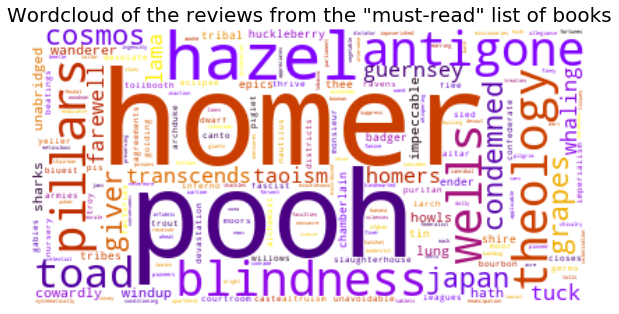

In [63]:
# Generating wordcloud for reviews of books on the positve list
gen_wordcloud(pos, 'Wordcloud of the reviews from the "must-read" list of books')

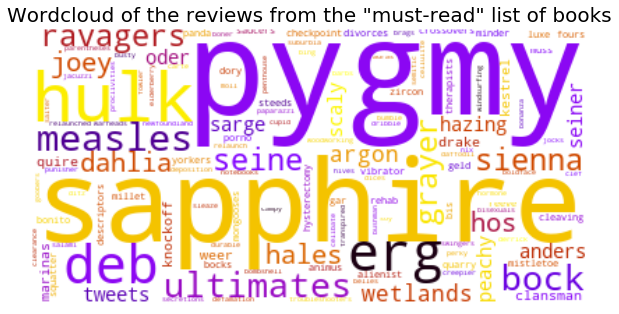

In [64]:
# Generating wordcloud for reviews of books on the negative list
gen_wordcloud(neg, 'Wordcloud of the reviews from the "must-read" list of books')

First thing to notice about these wordclouds is, that they don’t carry a lot of information. The words that are much more commonly mentioned in the positive list compared to the negative has no intuitive meaning for the difference in the two documents. The wordclouds seems to become very book specific seeing multiple references to Homers Odyssey such as "Homer" (the author), "Antigone" (one of the main characters) and perhaps pillars and grapes referring to old Greek mythology. It also seems like Winnie the Pooh might be more present in the positive list as well which is confirmed simply looking at titles including "Pooh".

In [ ]:
pos_books[pos_books.title.str.contains("Pooh")]

A total of 3 books on the positive list includes books about Winnie the Pooh or with references to it. This explains why the word is featured highly for the positive words. Looking at the words in highly present in the negative list it is seen that "Pygmy" stands out. Again, this is the title of a book in the negative list explaining why the word is more often mentioned for negative reviews.

In [ ]:
neg_books[neg_books.title.str.contains("Pygmy")]

The intuition about the dominant words for the reviews from the positive and negative list repectively, was that the words would carry a clear positive or negative sentiment. As this is not apparent from the TFIDF score a more sound way to investigate this hypothesis, is by sentiment analysis. 

#### Sentiment Analysis <a class="anchor" id="sentiment"></a>

Sentiment in text is the amount of emotion portrayed. Two methods can be used to calculate the sentiment of a text: a model can be trained on positive and negative data to learn nuances differentiating the two, or a rule-based approach can be used, where sentiment of a text is the result of a set of manually set rules. 
Often it is the rule-based approach that is used, as building a model to score automatically is both time-consuming and requires excessive amounts of data. 
The rule-based approach utilizes many Natural Language Processing methods such as tokenizing, stemming and part-of-speech (POS) tagging. The polarization of words is often the result of a look-up in a predefined lexical with polarity scores for certain words.
For this project we have used VADER (Valence Aware Dictionary and sentiment Reasoner) sentiment package in Python. The VADER library is a rule-based approach specifically appropriate for text from social media. It is a highly sophisticated package which takes the syntax of the sentence into account when scoring and thereby avoiding a common fall-back of the classical lexical approach, such as the incorporations of negations. Further, VADER has a sense of capitalization making words such as "GREAT" score higher than "great" as well as a sense of punctuation, letting multiple exclamation marks give a higher polarity score. 
The package is tuned for sentence-based sentiment but will for this purpose be used on full reviews for a single book some spanning several paragraphs. The final sentiment for the book is then the mean of the sentiment of the reviews for the book. 

The output from the VADER analysis is a negative, neutral, positive and compound score, where the compound score is the overall sentiment of the sentence and what is used in this analysis. 

Since VADER handles large unprocessed sentences, the cleaning of the data before parsing is sparse. All reviews are simply added as an entry in a dataframe and "\n” removed.

In [ ]:
def create_review_df(df, tag):
    '''
    Function splitting reviews from each book to entry in dataframe. 
    
    Parameters:
    df: Dataframe including review
    tag: tag to mark which dataframe books originated from 
    
    Value:
    Dataframe with entry as a single review. Column is added in order to preserve original index to map back to the
      book as well as column indicating tag for originating list of books. 
    '''
    df_out = []
    idx = []
    for i in range(len(df)):
        for j in range(len(df.review[i][0])):
            df_out.append(df.review[i][0][j])
            idx.append(i)
    df_out = pd.DataFrame(df_out)
    idx = pd.DataFrame(idx)
    df_out["pos"] = tag
    df_out["idx_original"] = idx
    return df_out

In [ ]:
# Resetting index 
neg_books = neg_books.reset_index(drop=True)
pos_books_reviewed = pos_books_reviewed.reset_index(drop=True)

# Splitting reviews
pos_df = create_review_df(pos_books_reviewed, 1)
neg_df = create_review_df(neg_books, 0)

In [ ]:
def clean_text_simple(df):
    '''
    Function taking a review and doing a simple cleaning inlcuding removing links and "\n". 
    
    Parameters:
    df: Dataframe with reviews
    
    Value: 
    Same structural dataframe but with cleaned reviews. 
    '''
    
    for i, review in enumerate(df[0]):
        rev = re.sub("(\\n\s*)", "", review)
        
        #Removing links
        rev = re.sub(r"(https:\/\/.*)", r' ', rev)
        
        df.iloc[i,0] = [rev]
    return df

In [ ]:
# Cleaning text
pos_df = clean_text_simple(pos_df)
neg_df = clean_text_simple(neg_df)

In [ ]:
# Setting sentiment analyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
def sentiment_analyzer_scores(sentence):
    '''
    Function getting polarity scores of a sentence
    
    Parameters: 
    sentence: string containing sentence to be score (in this analysis paragraphs are used aswell)
    
    Value:
    Dictionary including the negative, neutral, positive and compound score of the sentence
    '''
    score = analyser.polarity_scores(sentence)
    return score

In [ ]:
# Getting sentiment score for each review
pos_scored = pos_df[0].apply(lambda x: sentiment_analyzer_scores(x))
neg_scored = neg_df[0].apply(lambda x: sentiment_analyzer_scores(x))

In [ ]:
def unpack_dict(lst):
    '''
    Function unpacking the list of disctionaries produced in the sentiment analysis.
    
    Parameters: 
    lst: list of dictionaries
    
    Values:
    Dataframe with columns for each output of the sentiment score
    '''
    df = pd.DataFrame(lst)
    df["neg"] = [x.get("neg") for x in df[0]]
    df["neu"] = [x.get("neu") for x in df[0]]
    df["pos"] = [x.get("pos") for x in df[0]]
    df["compound"] = [x.get("compound") for x in df[0]]
    return df

In [ ]:
# Unpacking dictionaries
pos_scored = unpack_dict(pos_scored)
neg_scored = unpack_dict(neg_scored)

In [ ]:
# Setting reference index
pos_scored["idx_original"] = pos_df["idx_original"]
neg_scored["idx_original"] = neg_df["idx_original"]

In [ ]:
# Meaning sentiment over books
pos_final = pos_scored.groupby("idx_original")["compound"].mean()
neg_final = neg_scored.groupby("idx_original")["compound"].mean()

In [ ]:
# Plotting the distribution of sentiment for the two groups
plt.figure(figsize = (10,5))
sns.kdeplot(pos_final, color = 'red')
sns.kdeplot(neg_final, color = 'blue')
plt.xlabel('Sentiment score', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Distribution of sentiment for the two groups of books', fontsize = 18)
plt.legend(['Positive books', 'Negative books'], fontsize = 16)
plt.show()


## Helper Functions <a class="anchor" id="help"></a>


In [4]:
# Packages used only for helper functions
from IPython.display import Markdown, display

In [5]:
def printmd(string):
    display(Markdown(string))